# ACOM Tutorial Notebook - Basics trcilinic lattice.

In this tutorial, you will learn the basic concepts and syntax of the ACOM module in py4DSTEM. This notebook uses a made-up trcilinic cell to demonstrate functionality.

### Acknowledgements

This tutorial notebook was written by Colin Ophus and Steven Zeltmann. Contact clophus@lbl.gov with any questions.

### Versioning

Last updated on 2022-01-13 with py4DSTEM v.0.12.6.

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import py4DSTEM
import numpy as np

In [8]:
# Define manual triclinic structure using manual input
pos = np.array([
    [0.0, 0.0, 0.0],
])
atom_num = 74
cell = [3, 4, 5, 70, 90, 110]

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

In [9]:
# # Importing pymatgen - you need to install pymatgen if you want to use pymatgen structures or their cif importer.
# from pymatgen.core.structure import Structure, Lattice

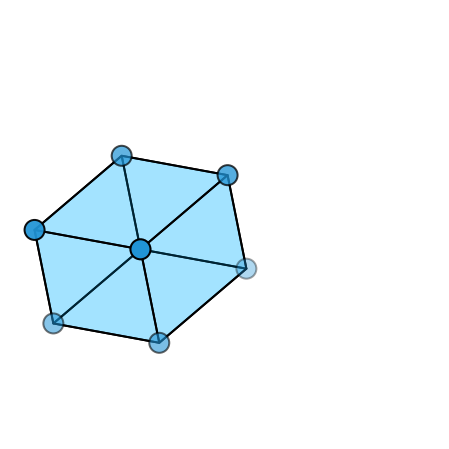

In [10]:
# Plot the structure
fig, ax = crystal.plot_structure(
    zone_axis_lattice=[1,1,1],
    camera_dist=11,
    perspective_axes=False,
    returnfig=True,
)

In [11]:
# Save the structure plot
# fig.savefig('plot_00_atomic_struct.pdf')

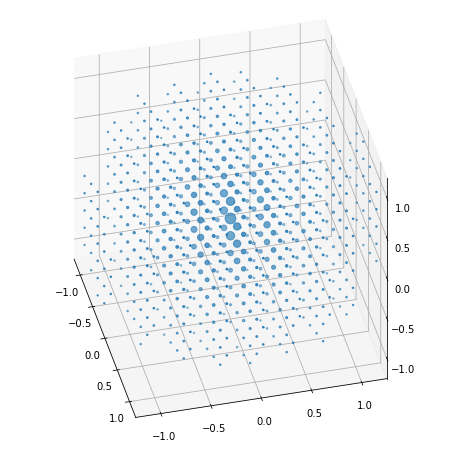

In [14]:
# Calculate and plot the structure factors
k_max = 1.5
crystal.calculate_structure_factors(k_max)

fig, ax = crystal.plot_structure_factors(
    zone_axis_lattice=[0,1,1],
    # zone_axis_cartesian=[1,1,1],
    plot_limit=1.2,
    perspective_axes=False,
    scale_markers = 2000,
    returnfig=True)

In [15]:
# Save the structure factor plot
# fig.savefig('plot_01_structure_factors.pdf')

### Generate and plot some diffraction patterns

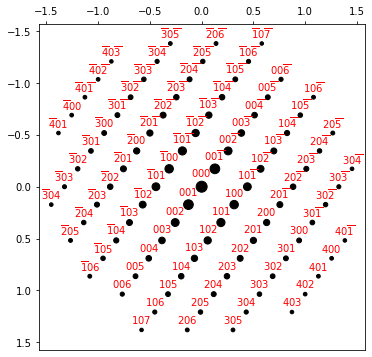

In [16]:
zone_axis_test = [0,1,0]  # Zone axis
x_proj_test = [1,0,1]  # in-plane projection vector

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis_lattice = zone_axis_test,
    proj_x_lattice = x_proj_test,
    # zone_axis_cartesian = zone_axis_test,
    # proj_x_cartesian = x_proj_test,
    sigma_excitation_error=0.02)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks,
)

### Testing orientation matching

In [24]:
# # Create an orientation plan
# crystal.orientation_plan(
#     angle_step_zone_axis = 2.0,
#     angle_step_in_plane = 2.0,
#     accel_voltage = 300e3,
#     corr_kernel_size=0.08,
# )

# Create an orientation plan with an automatic range of zone axes - this requires pymatgen to be installed!
crystal.orientation_plan(
    angle_step_zone_axis = 4.0,
    angle_step_in_plane = 3.0,
    accel_voltage = 300e3,
    corr_kernel_size=0.08,
    zone_axis_range='auto',
)

Automatically detected point group -1,
 using arguments: zone_axis_range = 
full, 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|████████████████████████████████████████████████████| 1013/1013 [00:01<00:00, 614.55 zone axes/s]


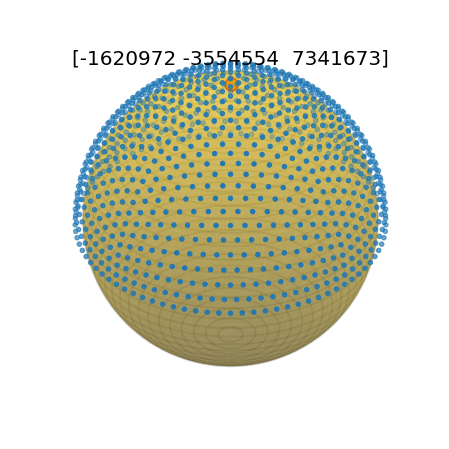

In [25]:
# Plot the zone axes included in the orientation plan
fig, ax = crystal.plot_orientation_zones(
    plot_limit=np.array([-0.8, 0.8]),
    returnfig=True)

In [26]:
# Save the zone axes orientation map
# fig.savefig('plot_02_zone_axes.pdf')

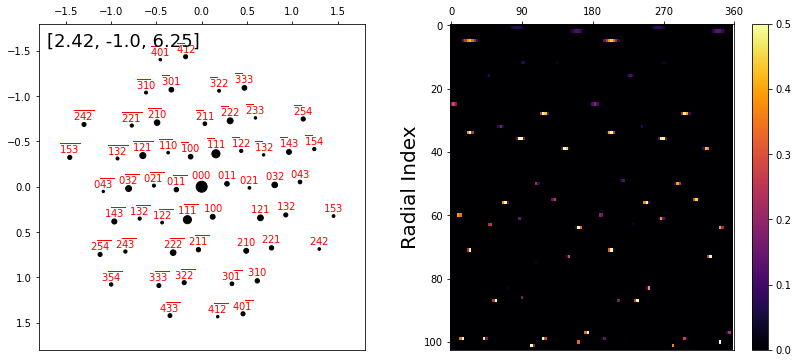

In [27]:
# Plot some of the orientation plans
fig, ax = crystal.plot_orientation_plan(
    zone_axis_lattice=[1,-2,3],
    returnfig=True,
);

In [28]:
# Save the zone axes orientation map
# fig.savefig('plot_03_plan_05.pdf')

Input zone axis    = ([-0.507 -0.169 -0.845])
Best fit lattice directions: z axis = ([0.521 0.128 0.844]), x axis = ([-0.684 -0.664  0.301]), with corr value = 0.808


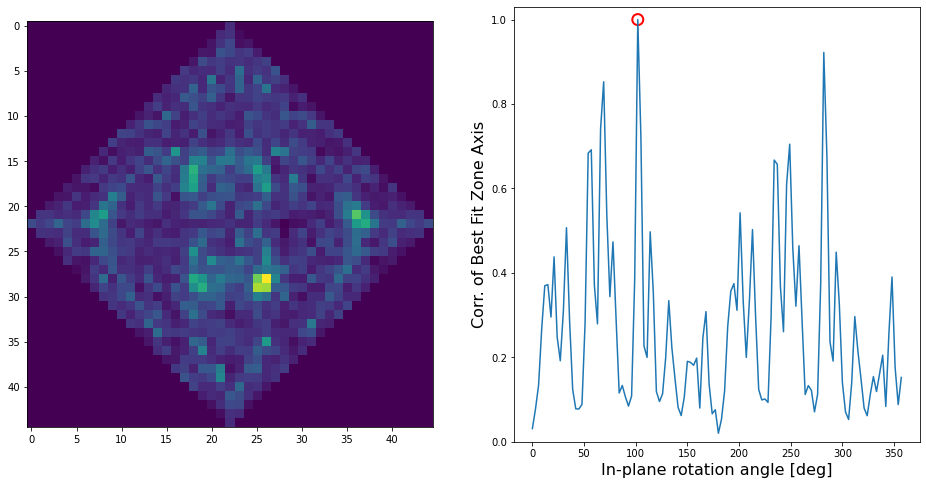

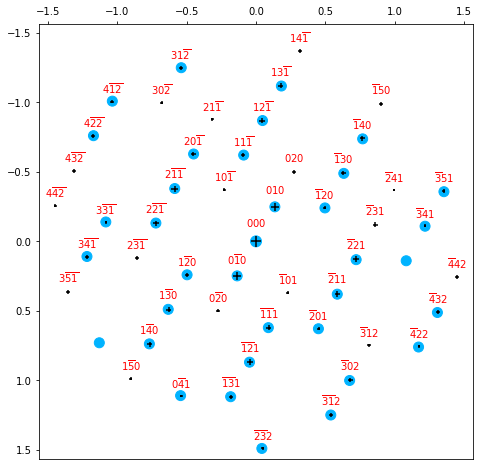

In [29]:
# Testing some matches - this cell shows the orientation correlogram, and the best match for both zone axis and in-plane rotation.
# zone_axis_test = np.array([1,0,-1])
zone_axis_test = np.array([-3,-1,-5])

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis_lattice = zone_axis_test,
    sigma_excitation_error=0.02)

# Print out zone axes after normalization
t = np.round(zone_axis_test/np.linalg.norm(zone_axis_test)*1e3)/1e3
print('Input zone axis    = (' + str(t) + ')')

# Perform matching, and plot correlation images
orientation, fig, ax = crystal.match_single_pattern(
    bragg_peaks,
    figsize=[8,4],
    plot_corr=True,
    verbose=True,
    returnfig=True,
#     inversion_symmetry=False,
)

# plot the match overlaid onto the input data
bragg_peaks_fit = crystal.generate_diffraction_pattern(
    orientation=orientation,
    sigma_excitation_error=0.025)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks,
    min_marker_size=100,
    figsize=(8,8)
)

In [381]:
# Save the correlation outputs
# fig.savefig('plot_04_match_00.pdf')

In [384]:
# Save the comparison plots
# fig.savefig('plot_05_comparison.pdf')